In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import muse.supplier as spr
import muse.processor as pcr
import muse.model2 as mdl
import muse.trainer as trn
import muse.visualizer as vis

import warnings
warnings.filterwarnings("ignore")

In [12]:
### ===== Hyperparameters ===== ###

mdl_name = 'dcgan_sample'
instrument = 'Piano'
filepath = "./../input/haydn/"
song_len = 200*4
stride = 200
epochs = 1000
learning_rate = 0.001
batch_size = 1
latent_size = 20

seed_load = np.random.randint(0,999999999)
seed_load = 21718471
seed_model = np.random.randint(0,999999999)
device = trn.get_device()

In [4]:
### ===== Data Preprocessing ===== ###

all_midis, filenames = pcr.get_midis(filepath) # load all .midi files
Corpus, instru2corpus = pcr.extract_notes_batch(all_midis) # extract all notes and sort by instrument
Corpus = pcr.remove_rare(Corpus, 0)[0] # remove notes that occur for less than $thre$ times
Corpus, fmap, rmap = pcr.get_map(Corpus) # get forward-map and reverse-map from corpus
instru2corpus = pcr.remove_short(instru2corpus) # remove songs that are too short
instru2corpus = pcr.upsample_batch(instru2corpus) # upsample notes according to multiples of duration
X_train, X_val, _, _ = pcr.train_test_split(instru2corpus, instrument, fmap, song_len, stride,\
                                                                                  seed=seed_load)
X_train, X_val = pcr.batchify(X_train), pcr.batchify(X_val) # reshape and turn into tensor
classes = len(set(Corpus)) # get number of unique keys

In [13]:
import torch.nn as nn

class discriminator(nn.Module):

    def __init__(self):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 3, 1)
        self.relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.pool = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(32, 64, 3, 1)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(12672, 4*4*64)
        self.linear2 = nn.Linear(4*4*64, 1)
        self.drop = nn.Dropout(p=0.5, inplace=True)

    def forward(self, I):
        h1 = self.drop(self.pool(self.relu(self.conv1(I))))
        h2 = self.drop(self.pool(self.relu(self.conv2(h1))))
        h3 = self.flatten(h2)
        h4 = self.relu(self.linear1(h3))
        o = self.linear2(h4)
        return o

In [20]:
import torch.optim as optim

torch.manual_seed(653562540)
D = discriminator()
model = mdl.cnn_varautoencoder(1, song_len//200, classes)
G = trn.load_model('vae3_melody_CE', model, device)[0].decoder

D_solver = optim.Adam(D.parameters(), lr = 0.0001, betas = (0.5,0.999))
G_solver = optim.Adam(G.parameters(), lr = 0.001, betas = (0.5,0.999))

epoch_start = 0
epochs = 30
dtype = torch.FloatTensor
eepoch = 100
iter_count = 0
switch_count = 0
D_loss, G_loss = [], []
save = True
seeds = [seed_load, seed_model]

sample_latent = lambda batch_size, latent_size: torch.FloatTensor(batch_size, latent_size).uniform_(0, classes)
sample_noise = lambda shape: torch.FloatTensor(*shape).uniform_(-classes//10, classes//10)

def bce_loss(input, target):
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

def discriminator_loss(logits_real, logits_fake, smooth=0.5, switch=False):
    N, _ = logits_real.size() 
    label_real_truth = smooth*torch.ones(N).type(dtype)
    label_fake_truth = torch.zeros(N).type(dtype)
    if not switch:
        label_real, label_fake = label_real_truth, label_fake_truth
    else:
        label_real, label_fake = label_fake_truth, label_real_truth
    loss = (bce_loss(logits_real, label_real))+(bce_loss(logits_fake, label_fake))
    return loss

def generator_loss(logits_fake):
    N, _ = logits_fake.size()
    loss = (bce_loss(logits_fake, torch.ones(N).type(dtype)))
    return loss

for epoch in range(epoch_start, epoch_start+epochs):
    for x in X_train:
        D_solver.zero_grad()
        real = x.type(dtype)
        logits_real = D(real).type(dtype)
        
        latent = sample_latent(1, latent_size).type(dtype)
        fake = G(latent).detach()*60
        noise = sample_noise(fake.shape)
        fake += noise
        logits_fake = D(fake)
        
        if switch_count % 3 == 0: switch = True
        else: switch = False
        d_error = discriminator_loss(logits_real, logits_fake, switch=switch)
        
        if d_error.item() > 0.9:
            d_error.backward()        
            D_solver.step()
        
        G_solver.zero_grad()
        latent = sample_latent(1, latent_size).type(dtype)
        fake = G(latent)*60
        logits_fake_G = D(fake)
        
        g_error = generator_loss(logits_fake_G)
        g_error.backward()
        G_solver.step()
        
        if not switch:
            D_loss.append(d_error.item())
            G_loss.append(g_error.item())
        
        if iter_count%eepoch == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_error.item(),g_error.item()))
        switch_count += 1
        iter_count += 1
        
    # save model
    if save:
        state = {'epoch': epoch, 'state_dict_D': D.state_dict(), 'state_dict_G': G.state_dict(),
        'D_loss': D_loss, 'G_losses':G_loss, 'seeds': seeds}
        torch.save(state, './models/'+mdl_name+'.pt')

Iter: 0, D: 263.4, G:1.783e+04
Iter: 100, D: 994.2, G:5.192e+03
Iter: 200, D: 35.68, G:6.642e+03
Iter: 300, D: 468.6, G:576.2
Iter: 400, D: 17.15, G:104.8
Iter: 500, D: 12.84, G:428.0
Iter: 600, D: 220.3, G:412.0
Iter: 700, D: 12.16, G:759.8
Iter: 800, D: 7.92, G:361.8
Iter: 900, D: 20.05, G:132.2
Iter: 1000, D: 4.875, G:77.11
Iter: 1100, D: 71.16, G:50.57
Iter: 1200, D: 113.8, G:520.9
Iter: 1300, D: 13.62, G:3.099e-06
Iter: 1400, D: 278.2, G:9.412
Iter: 1500, D: 21.4, G:17.23
Iter: 1600, D: 63.1, G:0.0
Iter: 1700, D: 3.177, G:31.05
Iter: 1800, D: 1.783, G:0.0
Iter: 1900, D: 14.32, G:56.74
Iter: 2000, D: 4.411, G:221.4
Iter: 2100, D: 3.126, G:0.0
Iter: 2200, D: 1.538, G:1.074
Iter: 2300, D: 3.681, G:0.0
Iter: 2400, D: 5.94, G:9.894e-06
Iter: 2500, D: 1.012, G:63.77
Iter: 2600, D: 2.621, G:141.8
Iter: 2700, D: 62.73, G:96.83
Iter: 2800, D: 4.394, G:38.73
Iter: 2900, D: 1.151, G:0.00165
Iter: 3000, D: 35.57, G:26.79
Iter: 3100, D: 0.7787, G:1.55
Iter: 3200, D: 5.339, G:35.77
Iter: 3300, 

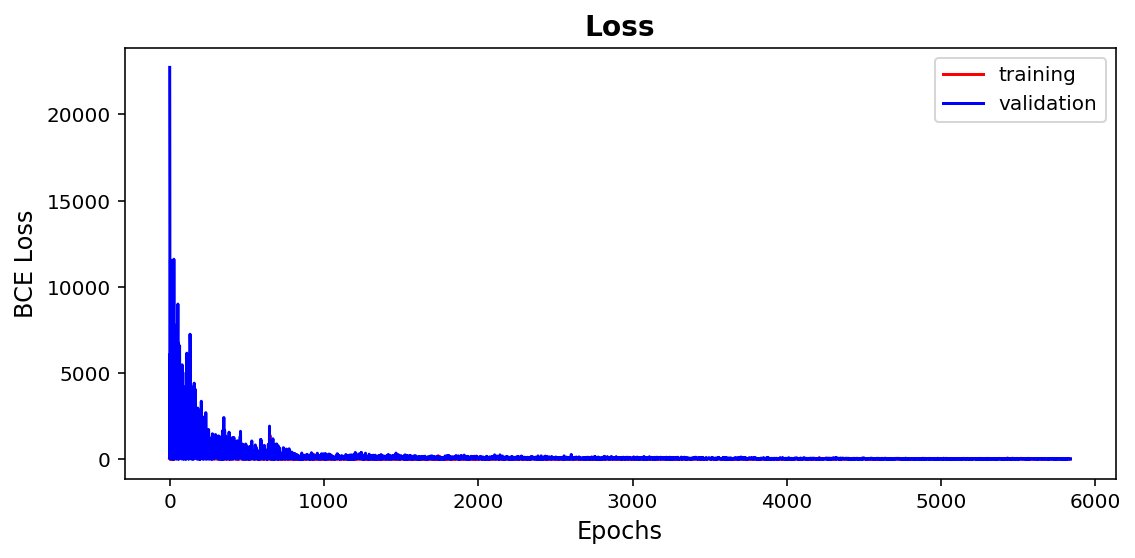

<Figure size 432x288 with 0 Axes>

In [21]:
vis.plot_train_val_loss(D_loss, G_loss, '', ylabel='BCE Loss', save=False)

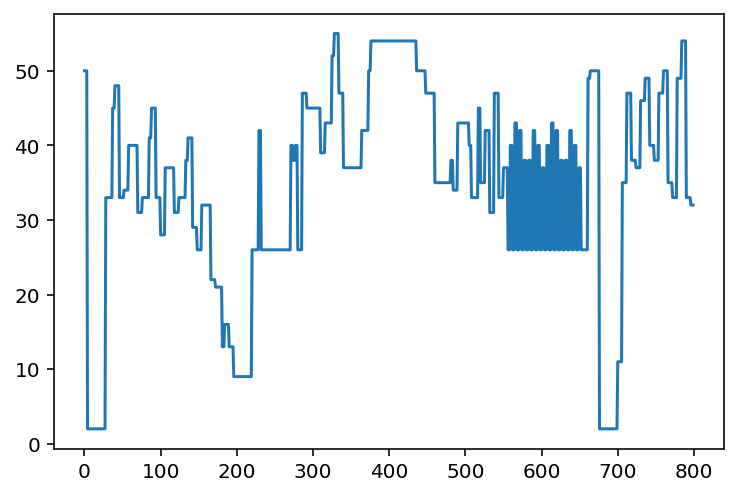

In [22]:
import matplotlib.pyplot as plt
plt.plot(real.view(-1).detach().numpy())

tensor([[23.2340, 17.5589, 31.8175,  9.4908, 34.1278,  4.2577, 53.1819, 15.0744,
          5.4404, 31.9652, 10.8491, 34.5966, 22.7150, 30.0658, 32.5727, 51.9160,
         27.8240,  7.2127,  1.1879, 57.6008]])


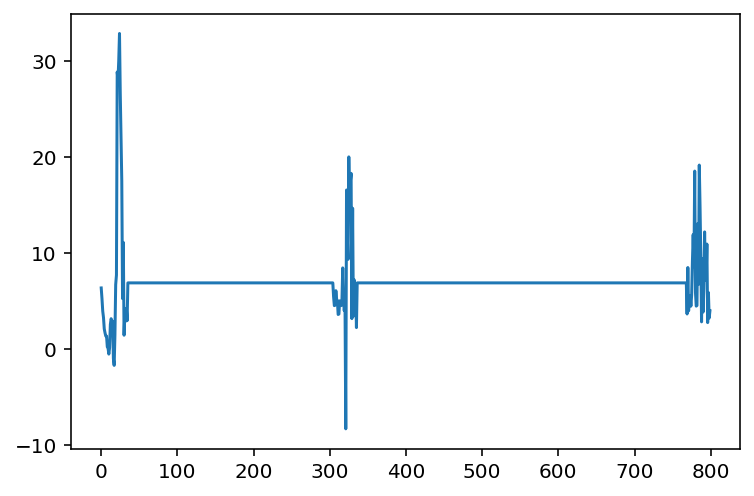

In [23]:
G.eval()
latent = sample_latent(1, latent_size).type(dtype)
print(latent)
fake2 = G(latent)

plt.plot(fake2.view(-1).detach().numpy())